In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
import numpy as np
from os import path, makedirs
from glob import glob
from cycler import cycler
from matplotlib.ticker import FormatStrFormatter
from collections import Counter
import statistics

import numbers


import warnings
import rpy2
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from os import path, makedirs
from glob import glob
from statsmodels.stats.anova import AnovaRM
from rpy2.robjects.packages import importr
# import rpy2

    
from utils import formats, full_passed_turkers, DATA_DIR
from utils import read_cond_file, get_attr, calc_SSRT, filter_ssrt_subs, get_p_str, ssrt_comparison
%matplotlib inline
%load_ext rpy2.ipython

# WRANGLING RAW DATA

In [2]:
def clean_data_initial(data_df, gocond='go'):
    
    useless_columns = ['SS_duration', 'SS_stimulus', 'battery_name',
                       'experiment_exp_id', 'finishtime', 'focus_shifts',
                       'full_screen', 'passed_check', 'possible_responses',
                       'time_elapsed', 'trial_type']


    test_data = data_df.query("exp_stage == 'test'")
    test_data.loc[:, 'stimulus'] = test_data['stimulus'].astype(str).apply(lambda x: x.split('.png')[0].split('/')[-1])
    test_data.loc[:, 'worker_id'] = test_data['worker_id'].astype(str).apply(lambda x: x.replace('s', '')).astype(int)

    test_data = test_data.drop(useless_columns, axis=1, errors='ignore')

    test_data = test_data.rename({'SS_trial_type': 'TrialType',
                         'SS_delay': 'StopSignalDelay',
                         'worker_id': 'Subject'}, axis=1)

    test_data.loc[test_data.TrialType!='stop', 'StopSignalDelay'] = np.nan

    test_data['GoTrialResponse'] = np.where(test_data.TrialType==gocond, test_data.key_press, np.nan)
    test_data['GoTrialCorrectResponse'] = np.where(test_data.TrialType==gocond, test_data.correct_response, np.nan)
    test_data['StopTrialResponse'] = np.where(test_data.TrialType=='stop', test_data.key_press, np.nan)


    test_data['GoRT'] = np.where(test_data.TrialType==gocond, test_data.rt, np.nan)
    test_data['StopFailureRT'] = np.where(test_data.TrialType=='stop', test_data.rt, np.nan)

    test_data = test_data.reset_index(drop=True)
    
    return test_data

In [3]:
def add_block(data_df, start_indices):
    data_df = data_df.copy()
    data_df['Block'] = np.nan

    for block_num, start_idx in enumerate(start_indices):
        block_idx = ((test_ss_data.trial_num >= start_idx) & (test_ss_data.trial_num < start_idx+50))
        data_df.loc[block_idx, 'Block'] = block_num + 1
    return data_df

In [4]:
output_cols = ['Subject',
     'Block',
     'TrialType',
     'GoTrialResponse',
     'GoTrialCorrectResponse',
     'StopTrialResponse',
     'GoRT',
     'StopFailureRT',
     'StopSignalDelay',
     'stimulus']

# simple high and low

In [5]:
raw_ss_data = pd.read_csv('RawTurkData/stop_signal.csv', index_col=0)

In [6]:
# split into high and low inorder to fit github's size limits
raw_ss_data.query("condition=='high'").to_csv('RawTurkData/stop_signal_high.csv', index=False)
raw_ss_data.query("condition=='low'").to_csv('RawTurkData/stop_signal_low.csv', index=False)


In [7]:
test_ss_data = clean_data_initial(raw_ss_data)
test_ss_data = add_block(test_ss_data, range(0,300,50))

/Users/henrymj/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
DataTurkSimpleHigh = test_ss_data.query('condition=="high"')
DataTurkSimpleHigh[output_cols].to_csv('CleanTurkData/DataTurkSimpleHigh.csv', index=False)

In [9]:
DataTurkSimpleLow = test_ss_data.query('condition=="low"')
DataTurkSimpleLow[output_cols].to_csv('CleanTurkData/DataTurkSimpleLow.csv', index=False)

## stim selective

In [10]:
raw_stim_ss_data = pd.read_csv('RawTurkData/stim_selective_stop_signal.csv', index_col=0)

In [11]:
raw_stim_ss_data['SS_trial_type'] = raw_stim_ss_data['condition']

In [12]:
test_stim_ss_data = clean_data_initial(raw_stim_ss_data)
test_stim_ss_data = add_block(test_stim_ss_data, range(0,300,50))

In [13]:
test_stim_ss_data[output_cols].to_csv('CleanTurkData/DataTurkStimSelec.csv', index=False)

## motor selective

In [14]:
def get_noncrit_key(data_df):
    data_df = data_df.copy()

    noncrit_keys = []
    crit_keys = []
    for key in data_df.correct_response.unique():
        conditions = data_df.query("correct_response=='%s'" % key).condition.unique()
        if 'ignore' in conditions:
            noncrit_keys.append(key)
        else:
            crit_keys.append(key)
    assert len(noncrit_keys)==1
    assert len(crit_keys)==1

    return noncrit_keys[0], crit_keys[0]

def fix_trialType_names(data_df):
    data_df = data_df.copy()
    noncrit_key, crit_key = get_noncrit_key(data_df)
    data_df['new_condition'] = np.nan
    data_df.loc[(data_df.condition=='go') & (data_df.correct_response==noncrit_key), 'new_condition'] = 'GoNoncritical'
    data_df.loc[(data_df.condition=='go') & (data_df.correct_response==crit_key), 'new_condition'] = 'go'
    data_df.loc[(data_df.condition=='ignore') & (data_df.correct_response==noncrit_key), 'new_condition'] = 'NonCritSignal'
    data_df.loc[(data_df.condition=='stop') & (data_df.correct_response==crit_key), 'new_condition'] = 'stop'
    data_df['SS_trial_type'] = data_df['new_condition']
    
    return data_df

In [15]:
raw_motor_ss_data = pd.read_csv('RawTurkData/motor_selective_stop_signal.csv', index_col=0)

In [16]:
new_group_data = pd.DataFrame()
for sub in raw_motor_ss_data.worker_id.unique():
    sub_df =  raw_motor_ss_data.query('worker_id=="%s"' % sub).copy()
    sub_df = fix_trialType_names(sub_df)
    new_group_data = pd.concat([new_group_data, sub_df], 0)

In [17]:
cleaned_group_data = clean_data_initial(new_group_data, gocond='go')

cleaned_motor_data = add_block(cleaned_group_data, range(0,300,50))

cleaned_motor_data[output_cols].to_csv('CleanTurkData/DataTurkMotorSelec.csv', index=False)

# Violation Analysis for each stimulus

In [18]:
def violation_analysis_mturk_stim_specific(d, save_results=False, verbose=False, stimulus='', sub_ssd_minimum=2):
    
    condition_name = 'UNKNOWN'
    if isinstance(d, str): #if it's a string, read in the file and print the condition name (used to v_a.ipynb)
        condition_name = d.replace('Data/Data', '').replace('.xlsx', '')#drop path and extension.
        if verbose: print(formats.BOLD + '*'*80 + formats.END)
        if verbose: print(formats.BOLD + condition_name + formats.END)
        d = read_cond_file(d)
        
    
    if 'GoCriticalRT' in d.columns: 
        go_key = 'GoCriticalRT'
    elif 'Target.RT' in d.columns: #ADDED FOR MATZKE DATA
        go_key = 'Target.RT'
    else: 
        go_key = 'GoRT'
    
        
    stopFailRT = 'StopFailureRT'
    if 'TargetDelay.RT' in d.columns: stopFailRT = 'TargetDelay.RT' #ADDED FOR MATZKE DATA
        
    
    if 'Block' not in d.columns: d['Block'] = 1 #ADDED FOR MATZKE DATA - insert dummy block
    
    info = []
    condition_subjects = d.Subject.unique()
    if len(condition_subjects)==522: condition_subjects = full_passed_turkers
    for subject in condition_subjects:
        subdata = d.query('Subject == %d' % subject)
        if verbose: print('subject %d: found %d trials' % (subject, subdata.shape[0]))
        ssdvals = [i for i in subdata.StopSignalDelay.unique() if isinstance(i, float) and i >=0] #ignore nan/missing values and 0/negative SSDs
        ssdvals.sort()

        # You find all pairs of trials in which the first is a go trials with a response and the second is a 
        # stop trial with a response. Both trials need to come from the same subject and block. 
        # This should be done separately for each SSD. Then the RT for the first trial in the pair should be 
        # subtracted from the second. This is the core analysis per SSD per subject.

        for ssd in ssdvals:
            ssd_data = subdata.query('(StopSignalDelay == %d) & (stimulus == "%s")' % (ssd, stimulus))
            signal_respond_data = ssd_data.dropna(subset=[stopFailRT])
            signal_respond_data = signal_respond_data.loc[signal_respond_data[stopFailRT] > 0, :]
            # for each signal respond trial, determine whether the previous trial was a go trial in the same block
            signal_respond_data['MatchingGo'] = np.nan
            if signal_respond_data.shape[0] > 0:
                for t in signal_respond_data.index:
                    if t < 1:
                        continue
                    prevtrial = d.loc[int(t) - 1, :]
                    if prevtrial.Block == signal_respond_data.loc[t, 'Block']: # blockmatch
                        if (prevtrial[go_key] > 0.0): #skip omissions
                            signal_respond_data.loc[t, 'MatchingGo'] = prevtrial[go_key]
                signal_respond_data = signal_respond_data.dropna(subset=['MatchingGo'])
            # I expect to see RuntimeWarnings when there only nans passed to nanmean (i.e. no stop failures and/or preceding GoRTs at some ssd)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                info.append([subject, 
                             ssd, 
                             ssd_data.shape[0], 
                             signal_respond_data.shape[0],
                             np.nanmean(signal_respond_data[stopFailRT]\
                                          - signal_respond_data.MatchingGo),
                             np.nanmean(signal_respond_data[stopFailRT]),
                             np.nanmean(signal_respond_data.MatchingGo)])

    info_df = pd.DataFrame(info, columns=['subject', 'ssd', 'nstoptrials', 
                                             'n_matched_go', 'mean_violation', 'mean_stopFailureRT', 'mean_precedingGoRT'])


    # However, I only include data at a given SSD for a given subject
    # (for things like figures or inferential stats) if there are at least 2 pairs of trials for that subject. 

    info_df = info_df.query('n_matched_go >= %d' % sub_ssd_minimum)

    # And I only include an SSD for the experiment (for things like Figure 1) if 
    # 5 subjects have at least 2 pairs of trials for that SSD. So to reproduce the main data, 
    # you'll want to apply these same thresholds.

    all_ssdvals = info_df.ssd.unique()
    all_ssdvals.sort()

    for ssd in all_ssdvals:
        info_df_ssd = info_df.query('ssd == %d' % ssd)
        if verbose: print(ssd, 'n subs with data:', info_df_ssd.shape[0])
        if info_df_ssd.shape[0] < 5:
            info_df = info_df.query('ssd != %d' % ssd)
            if verbose: print('dropping', ssd)
    
    return info_df

In [19]:
def get_and_plot_violations_by_stim(va_dict):
    violation_by_SSD_perCondition = None
    for condition_name, curr_df in va_dict.items():
        curr_violation_series = curr_df.groupby('ssd').mean()['mean_violation'] #get the mean violation per SSD across subjects as a pd Series
        curr_violation_series.name = condition_name #name the series after the condition
        if violation_by_SSD_perCondition is None: #create or add the series to a full DF
            violation_by_SSD_perCondition = curr_violation_series
        else:
            violation_by_SSD_perCondition = pd.concat([violation_by_SSD_perCondition,
                                                       curr_violation_series], axis=1)

    print(violation_by_SSD_perCondition.head(6))
    if len(violation_by_SSD_perCondition) > 1:
        _ = plt.plot(violation_by_SSD_perCondition.interpolate(limit_area='inside', method='slinear'), alpha=0.75)
        _ = plt.legend(violation_by_SSD_perCondition.columns)
        plt.show()
        plt.close()
    return(violation_by_SSD_perCondition)

In [20]:
# mean across high and low stims which are the same
def mean_high_and_low_violations(violations_by_ssd_by_stim):
    df = violations_by_ssd_by_stim.copy()
    return df.groupby(by=df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])

In [21]:
def correlate_violations_with_visdegs(violations_by_ssd_by_stim, visual_angles):
    violations_by_ssd_by_stim = mean_high_and_low_violations(violations_by_ssd_by_stim)
    visual_angles = visual_angles[violations_by_ssd_by_stim.columns]

    violation_angle_corr_by_ssd = pd.concat([violations_by_ssd_by_stim, visual_angles], 0).T.corr().loc['VA diff', violations_by_ssd_by_stim.T.columns]
    
    if len(violation_angle_corr_by_ssd) > 1:
        plt.plot(violation_angle_corr_by_ssd)
    print(violation_angle_corr_by_ssd)

In [22]:
visual_angles = pd.read_csv('CleanTurkData/mturk_stop_tasks_visual_degrees.csv')
visual_angles = visual_angles[['shape name', 'VA diff']].set_index('shape name').T

data_dict = {}
data_dict['simpleHigh'] = pd.read_csv('CleanTurkData/DataTurkSimpleHigh.csv')
data_dict['simpleLow'] = pd.read_csv('CleanTurkData/DataTurkSimpleLow.csv')
data_dict['stimSelec'] = pd.read_csv('CleanTurkData/DataTurkStimSelec.csv')
data_dict['motorSelec'] = pd.read_csv('CleanTurkData/DataTurkMotorSelec.csv')

simpleHigh
            tear   hourglass     square   pentagon
ssd                                               
0.0    42.833333   93.809524   4.384722  23.140741
100.0 -20.366667  114.266667  28.872222  86.338095
150.0 -39.583333  -25.077381 -21.146032  49.478070
200.0  -7.229885   -0.134195 -24.314583  16.118333
250.0 -30.427822  -26.656868 -52.187443   2.491199
300.0 -34.040896  -38.874149 -45.642293 -26.667184


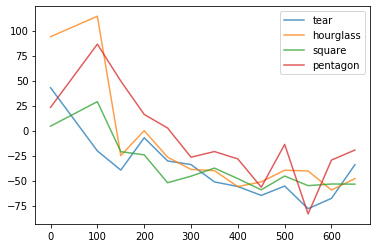

simpleLow
        pentagon  hourglass     square       tear
ssd                                              
0.0          NaN  72.642857        NaN  32.550000
100.0        NaN  14.410256  52.469697  -1.195238
150.0  39.547436   2.248148  -0.700000  14.863131
200.0   5.671345   1.281190 -14.367505  -6.754792
250.0   8.399780 -23.386502 -29.439286 -28.480792
300.0 -18.065722 -32.098801 -40.850869 -36.891793


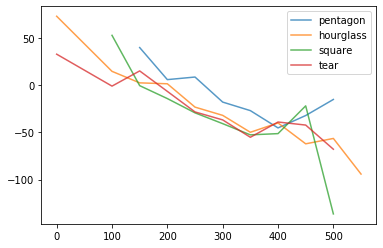

stimSelec
            moon   trapezoid       oval  rectangle
ssd                                               
0.0    79.991667  158.718056  20.166667  80.833333
50.0   33.075000   52.166667        NaN  82.240741
100.0  32.266667   40.285714  82.312500  74.648148
150.0  25.083333   59.047980  35.710145  23.005376
200.0  -0.062000   48.617521  24.042424  -0.031046
250.0 -14.370482   19.914899  -0.055778   3.964689


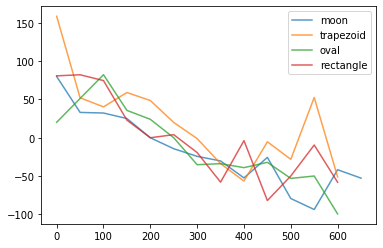

motorSelec
           circle    rhombus     Lshape   triangle
ssd                                               
0.0    150.166667  76.770833   4.437500  78.900000
100.0         NaN        NaN        NaN  27.777778
150.0   31.107143  60.300000  20.518519  28.944444
200.0  -17.477273  25.488889 -13.830357 -25.456140
250.0  -57.178571   8.939103 -10.916667 -18.894309
300.0  -42.264744 -28.269231 -35.351562 -65.829630


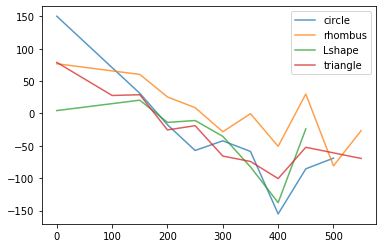

In [23]:
violations_by_ssd_by_stim = pd.DataFrame()
for title, data_df in data_dict.items():
    print(title)
    va_dict = {}
    for stim in data_df.stimulus.unique():
        va_dict[stim] = violation_analysis_mturk_stim_specific(data_df, stimulus=stim)
    violations_by_ssd_by_stim = pd.concat([violations_by_ssd_by_stim, get_and_plot_violations_by_stim(va_dict)], 1, sort=True)

## lower threshold to 1 pair per ssd per subject to increase SNR

simpleHigh
            tear   hourglass     square   pentagon
ssd                                               
0.0    58.866667   62.041667  84.034259  39.913333
50.0   34.904762   39.500000  88.847222  43.211538
100.0 -19.801587  132.355556  27.301389  77.014667
150.0  27.496377  -19.371377  35.398889  69.960884
200.0  -4.260753  -23.840205 -22.972268  27.723304
250.0 -45.185435  -27.672045 -54.085659 -11.939485


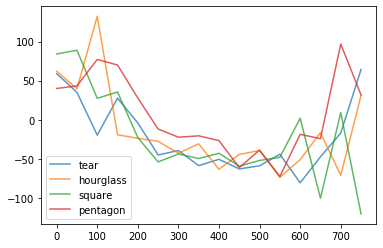

simpleLow
         pentagon  hourglass      square       tear
ssd                                                
0.0    -31.142857  77.291667  102.630952  52.311765
50.0   152.772727  80.333333  121.950000  15.500000
100.0   70.946429   7.980952   51.079167  55.959804
150.0   56.083111  -0.843446    7.714286  21.288039
200.0    9.592394  -1.995675  -10.331741   0.887219
250.0    8.724879 -29.299493  -21.698328 -20.487855


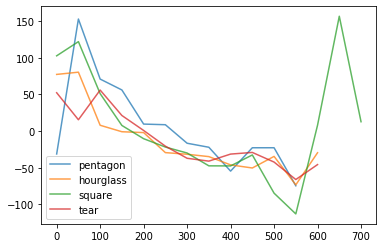

stimSelec
            moon   trapezoid       oval   rectangle
ssd                                                
0.0    45.448925  109.744667  62.956989  123.096774
50.0   64.905556   88.959770  80.506173  107.209402
100.0  36.318954   73.120000  57.798077   94.559028
150.0  27.760638   67.890693  59.934272   20.675725
200.0   8.576423   19.992361  19.845144   17.807943
250.0 -29.016667   17.144342  -1.620955   -5.421601


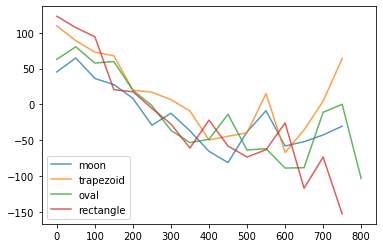

motorSelec
           circle     rhombus     Lshape    triangle
ssd                                                 
0.0    108.872549   87.256944  48.815789   46.880952
50.0    88.340000  104.740741  18.431818  105.638889
100.0  125.625000   90.687500  41.869565   25.424242
150.0   22.662500   62.950000  -0.888889   51.865854
200.0   22.291045   48.045752  -4.050781  -18.629630
250.0  -53.741758  -16.351190 -30.058333  -28.662963


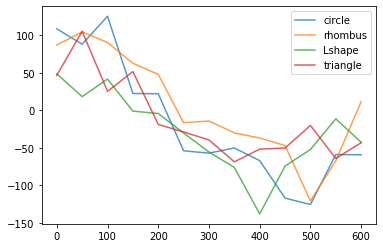

In [24]:
violations_by_ssd_by_stim = pd.DataFrame()
for title, data_df in data_dict.items():
    print(title)
    va_dict = {}
    for stim in data_df.stimulus.unique():
        va_dict[stim] = violation_analysis_mturk_stim_specific(data_df, stimulus=stim, sub_ssd_minimum=1)
    violations_by_ssd_by_stim = pd.concat([violations_by_ssd_by_stim, get_and_plot_violations_by_stim(va_dict)], 1, sort=True)

ssd
0.0      0.205513
50.0     0.396989
100.0    0.696697
150.0    0.406673
200.0    0.806155
250.0    0.077679
300.0   -0.052484
350.0    0.089907
400.0    0.237500
450.0   -0.033242
500.0   -0.772721
550.0   -0.360420
600.0    0.130901
650.0   -0.557642
700.0    0.234636
750.0   -0.124207
800.0         NaN
Name: VA diff, dtype: float64


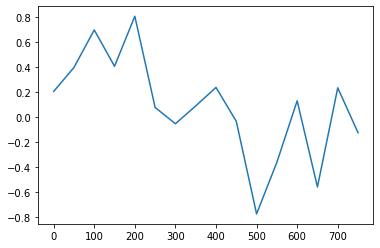

In [25]:
correlate_violations_with_visdegs(violations_by_ssd_by_stim, visual_angles)

# group short SSDs

In [26]:
def violation_analysis_mturk_stim_specific_clump_short_ssds(d, save_results=False, verbose=False, stimulus='', sub_ssd_minimum=2):
    
    condition_name = 'UNKNOWN'
    if isinstance(d, str): #if it's a string, read in the file and print the condition name (used to v_a.ipynb)
        condition_name = d.replace('Data/Data', '').replace('.xlsx', '')#drop path and extension.
        if verbose: print(formats.BOLD + '*'*80 + formats.END)
        if verbose: print(formats.BOLD + condition_name + formats.END)
        d = read_cond_file(d)
        
    
    if 'GoCriticalRT' in d.columns: 
        go_key = 'GoCriticalRT'
    elif 'Target.RT' in d.columns: #ADDED FOR MATZKE DATA
        go_key = 'Target.RT'
    else: 
        go_key = 'GoRT'
    
        
    stopFailRT = 'StopFailureRT'
    if 'TargetDelay.RT' in d.columns: stopFailRT = 'TargetDelay.RT' #ADDED FOR MATZKE DATA
        
    
    if 'Block' not in d.columns: d['Block'] = 1 #ADDED FOR MATZKE DATA - insert dummy block
    
    info = []
    condition_subjects = d.Subject.unique()
    if len(condition_subjects)==522: condition_subjects = full_passed_turkers
    for subject in condition_subjects:
        subdata = d.query('Subject == %d' % subject)
        if verbose: print('subject %d: found %d trials' % (subject, subdata.shape[0]))
        ssdvals = [i for i in subdata.StopSignalDelay.unique() if isinstance(i, float) and i >=0] #ignore nan/missing values and 0/negative SSDs
        ssdvals.sort()

        # You find all pairs of trials in which the first is a go trials with a response and the second is a 
        # stop trial with a response. Both trials need to come from the same subject and block. 
        # This should be done separately for each SSD. Then the RT for the first trial in the pair should be 
        # subtracted from the second. This is the core analysis per SSD per subject.

        ssd = 200
        ssd_data = subdata.query('(StopSignalDelay < %d) & (stimulus == "%s")' % (ssd, stimulus))
        signal_respond_data = ssd_data.dropna(subset=[stopFailRT])
        signal_respond_data = signal_respond_data.loc[signal_respond_data[stopFailRT] > 0, :]
        # for each signal respond trial, determine whether the previous trial was a go trial in the same block
        signal_respond_data['MatchingGo'] = np.nan
        if signal_respond_data.shape[0] > 0:
            for t in signal_respond_data.index:
                if t < 1:
                    continue
                prevtrial = d.loc[int(t) - 1, :]
                if prevtrial.Block == signal_respond_data.loc[t, 'Block']: # blockmatch
                    if (prevtrial[go_key] > 0.0): #skip omissions
                        signal_respond_data.loc[t, 'MatchingGo'] = prevtrial[go_key]
            signal_respond_data = signal_respond_data.dropna(subset=['MatchingGo'])
        # I expect to see RuntimeWarnings when there only nans passed to nanmean (i.e. no stop failures and/or preceding GoRTs at some ssd)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            info.append([subject, 
                         ssd, 
                         ssd_data.shape[0], 
                         signal_respond_data.shape[0],
                         np.nanmean(signal_respond_data[stopFailRT]\
                                      - signal_respond_data.MatchingGo),
                         np.nanmean(signal_respond_data[stopFailRT]),
                         np.nanmean(signal_respond_data.MatchingGo)])

    info_df = pd.DataFrame(info, columns=['subject', 'ssd', 'nstoptrials', 
                                             'n_matched_go', 'mean_violation', 'mean_stopFailureRT', 'mean_precedingGoRT'])

    # However, I only include data at a given SSD for a given subject
    # (for things like figures or inferential stats) if there are at least 2 pairs of trials for that subject. 

    info_df = info_df.query('n_matched_go >= %d' % sub_ssd_minimum)
    
    return info_df

In [27]:
violations_by_ssd_by_stim = pd.DataFrame()
for title, data_df in data_dict.items():
    print(title)
    va_dict = {}
    for stim in data_df.stimulus.unique():
        va_dict[stim] = violation_analysis_mturk_stim_specific_clump_short_ssds(data_df, stimulus=stim)
    violations_by_ssd_by_stim = pd.concat([violations_by_ssd_by_stim, get_and_plot_violations_by_stim(va_dict)], 1, sort=True)

simpleHigh
         tear  hourglass     square   pentagon
ssd                                           
200  13.90625  27.718939  22.859219  58.250222
simpleLow
      pentagon  hourglass    square       tear
ssd                                           
200  51.491135      10.67  26.66761  30.368167
stimSelec
          moon  trapezoid       oval  rectangle
ssd                                            
200  37.648776  76.483683  64.348413  71.886626
motorSelec
        circle    rhombus     Lshape   triangle
ssd                                            
200  77.450298  74.603711  21.752315  51.200737


In [30]:
# simple
def get_condition_correlation(title, indices):
    stimulus_vals = violations_by_ssd_by_stim.iloc[:, indices].copy()
    df_to_corr = pd.concat([stimulus_vals, visual_angles[stimulus_vals.columns]]).T
    print('%s: ' % title, df_to_corr.corr().loc['VA diff', stimulus_vals.T.columns].values[0])
    return df_to_corr

In [31]:
arg_tuples = [('SimpleHigh', np.arange(0,4)),
              ('SimpleLow', np.arange(4,8)),
              ('StimSelec', np.arange(8,12)),
              ('MotorSelec', np.arange(12,16))]

condition_correlations = {}
for title, indices in arg_tuples:
    condition_correlations[title] = get_condition_correlation(title, indices)

SimpleHigh:  0.9697027665113906
SimpleLow:  0.8388040909339097
StimSelec:  0.2564277294076275
MotorSelec:  0.8485687278516499


In [37]:
condition_correlations['SimpleHigh']

,200,VA diff
shape name,,
tear,13.906250,0.095716
hourglass,27.718939,0.155099
square,22.859219,0.149953
pentagon,58.250222,1.064162


In [33]:
condition_correlations['SimpleLow']

,200,VA diff
shape name,,
pentagon,51.491135,1.064162
hourglass,10.670000,0.155099
square,26.667610,0.149953
tear,30.368167,0.095716


In [34]:
condition_correlations['StimSelec']

,200,VA diff
shape name,,
moon,37.648776,0.117452
trapezoid,76.483683,0.136609
oval,64.348413,1.811298
rectangle,71.886626,0.922167


In [35]:
condition_correlations['MotorSelec']

,200,VA diff
shape name,,
circle,77.450298,1.862575
rhombus,74.603711,2.285602
Lshape,21.752315,0.215266
triangle,51.200737,0.114296
